In [300]:
# import numpy as np
import pandas as pd

In [301]:
df = pd.read_csv('data/spam.csv', encoding='ISO-8859-1')

In [302]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2369,ham,A Boy loved a gal. He propsd bt she didnt mind...,NaN,NaN,NaN
1139,ham,Message:some text missing* Sender:Name Missing...,NaN,NaN,NaN
587,ham,\Pete can you please ring meive hardly gotany ...,NaN,NaN,NaN
4016,ham,Eek that's a lot of time especially since Amer...,NaN,NaN,NaN
4357,spam,Our dating service has been asked 2 contact U ...,NaN,NaN,NaN


In [303]:
df.shape

(5572, 5)

1. Data Cleaning
2. EDA
3. Text Preprocessing
4. Model Building
5. Evaluation
6. Improvement
7. Website
8. Deploy

# 1. Data Cleaning


In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [305]:
# drop last 3 cols
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [306]:
df.sample(5)

,v1,v2
5313,ham,My sister going to earn more than me da.
3984,ham,"Whatever, juliana. Do whatever you want."
4632,ham,Oh wow thats gay. Will firmware update help
5037,ham,Thanks for being there for me just to talk to ...
4791,ham,Gd luck 4 ur exams :-)


# Renaming the columns

In [307]:
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)
df.sample(5)

,target,text
3457,ham,Have your lunch and come quickly and open the ...
4308,ham,He dint tell anything. He is angry on me that ...
4435,ham,"House-Maid is the murderer, coz the man was mu..."
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny
1380,ham,i dnt wnt to tlk wid u


In [308]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [309]:
df['target'] = encoder.fit_transform(df['target'])

In [310]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Missing values

In [311]:
df.isnull().sum()

target    0
text      0
dtype: int64

# Check for duplicate values

In [312]:
df.duplicated().sum()

np.int64(403)

# Remove duplicates

In [313]:
df = df.drop_duplicates(keep='first')

In [314]:
df.duplicated().sum()

np.int64(0)

In [315]:
df.shape

(5169, 2)

# 2. EDA

Розвідувальний аналіз даних (РАД) - це спосіб оцінювання наборів даних з метою виокремлення їхніх суттєвих властивостей, як правило, з використанням візуальних підходів.

In [316]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [317]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

Бачимо, що кількість емейлів без спаму 4516, а з спамом - 653

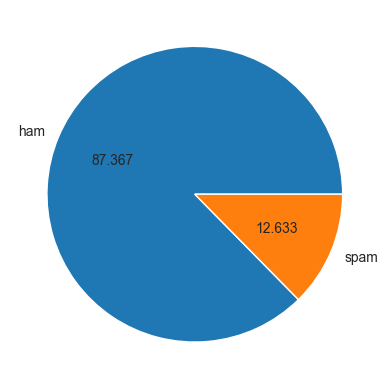

In [318]:
import matplotlib.pyplot as plt

plt.pie(df['target'].value_counts(), labels=["ham", "spam"], autopct='%0.3f')
plt.show()

Бачимо по пайчарту, що 87.367% емейлів без спаму, а з спамом - 12.633%.

Але маємо імбаланс даних (трошки)

In [319]:
import nltk

In [320]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to E:\CodeDataBase_PC\SMS-Spam-
[nltk_data]     Classifier\.venv\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to E:\CodeDataBase_PC\SMS-
[nltk_data]     Spam-Classifier\.venv\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to E:\CodeDataBase_PC\SMS-
[nltk_data]     Spam-Classifier\.venv\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to E:\CodeDataBase_PC\SMS-
[nltk_data]     Spam-Classifier\.venv\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [321]:
df['num_characters'] = df['text'].apply(len)

In [322]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


# Num of words

In [323]:
df['nums_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x, language='english', preserve_line=True)))

In [324]:
df.head()

,target,text,num_characters,nums_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [325]:
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x, language='english')))

In [326]:
df.head()

,target,text,num_characters,nums_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [327]:
df[['num_characters', 'nums_words', 'num_sentences']].describe()

,num_characters,nums_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,17.864964,1.965564
std,58.236293,12.776749,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,14.000000,1.000000
75%,117.000000,25.000000,2.000000
max,910.000000,215.000000,38.000000


In [328]:
# Емейли без спаму
df[df['target'] == 0][['num_characters', 'nums_words', 'num_sentences']].describe()

,num_characters,nums_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,16.618468,1.820195
std,56.358207,12.962931,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,21.000000,2.000000
max,910.000000,215.000000,38.000000


In [329]:
# Емейли з спамом
df[df['target'] == 1][['num_characters', 'nums_words', 'num_sentences']].describe()

,num_characters,nums_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,26.485452,2.970904
std,30.137753,6.717242,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,24.000000,2.000000
50%,149.000000,28.000000,3.000000
75%,157.000000,31.000000,4.000000
max,224.000000,46.000000,9.000000


In [330]:
import seaborn as sns

<Axes: xlabel='num_characters', ylabel='Count'>

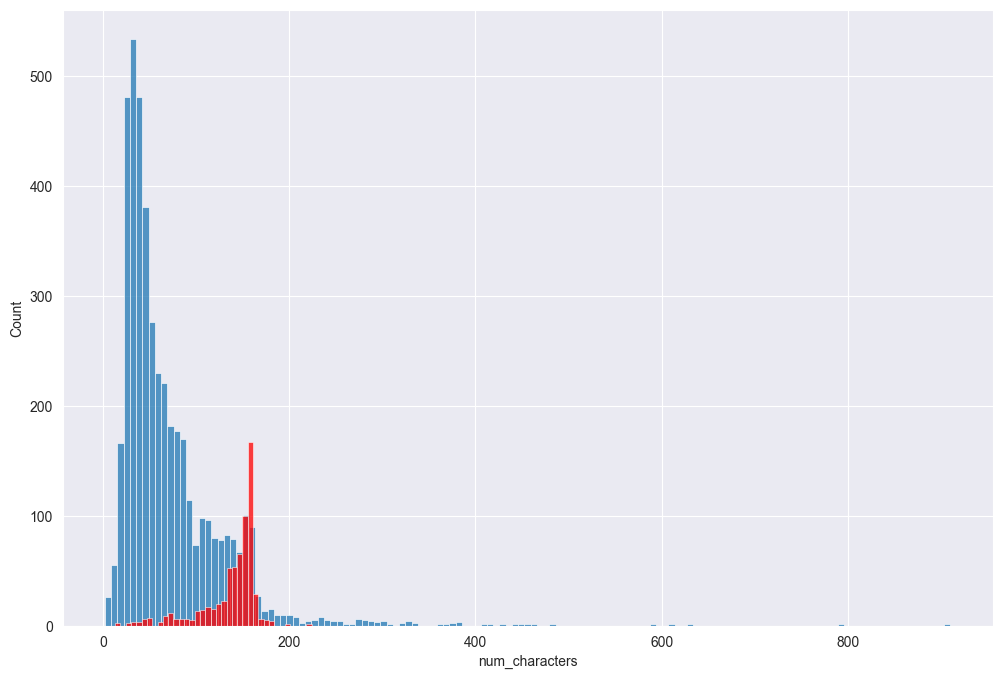

In [331]:
plt.figure(figsize=(12, 8))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'], color='red')

<Axes: xlabel='nums_words', ylabel='Count'>

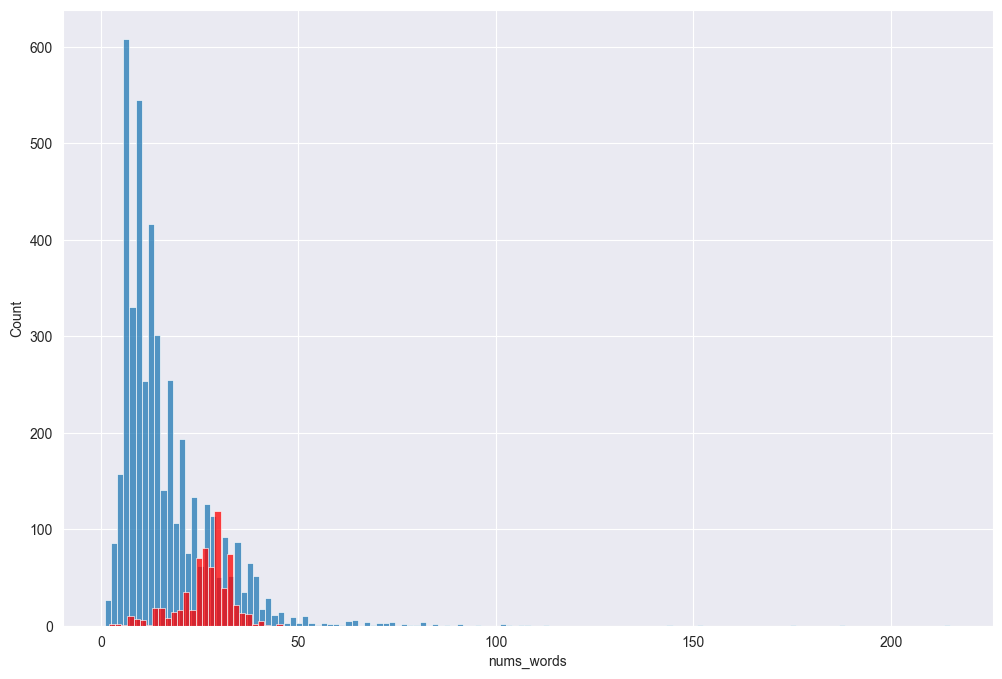

In [332]:
plt.figure(figsize=(12, 8))
sns.histplot(df[df['target'] == 0]['nums_words'])
sns.histplot(df[df['target'] == 1]['nums_words'], color='red')

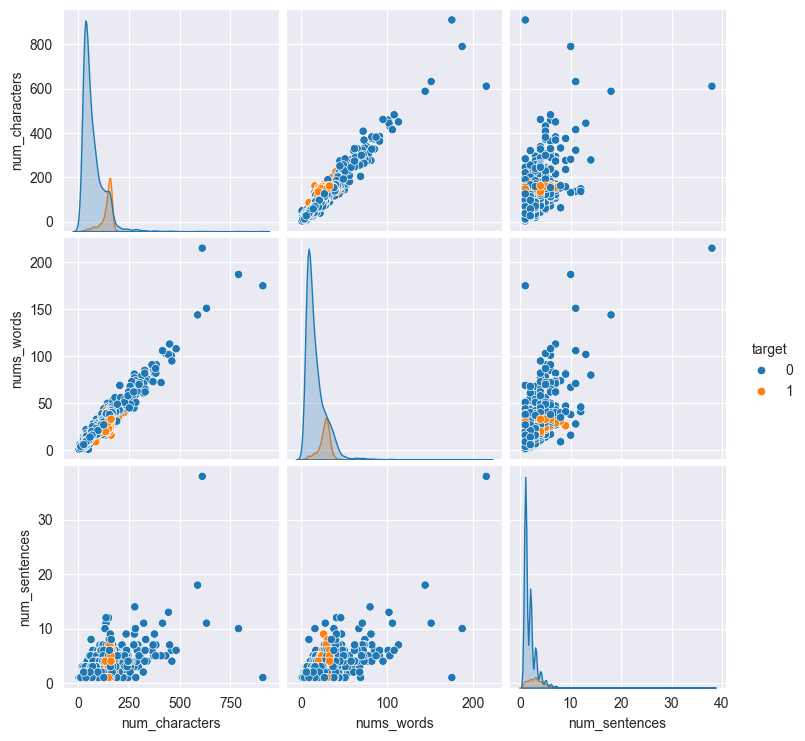

In [333]:
sns.pairplot(df, hue='target')

# 3. Data Preprocessing

In [334]:
import string
from nltk.corpus import stopwords

nltk.download('stopwords')

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text, language='english', preserve_line=True)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

[nltk_data] Downloading package stopwords to E:\CodeDataBase_PC\SMS-
[nltk_data]     Spam-Classifier\.venv\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [366]:
transform_text('Hi how are you Andrii?')

'hi andrii'

In [367]:
df['text'][1000]

'No..but heard abt tat..'

In [368]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

ps.stem('loving')

'love'

In [338]:
df['transformed_text'] = df['text'].apply(transform_text)

In [339]:
df.head()

,target,text,num_characters,nums_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [340]:
from wordcloud import WordCloud

wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

In [341]:
df['transformed_text'] = df['transformed_text'].fillna("").astype(str)


In [342]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

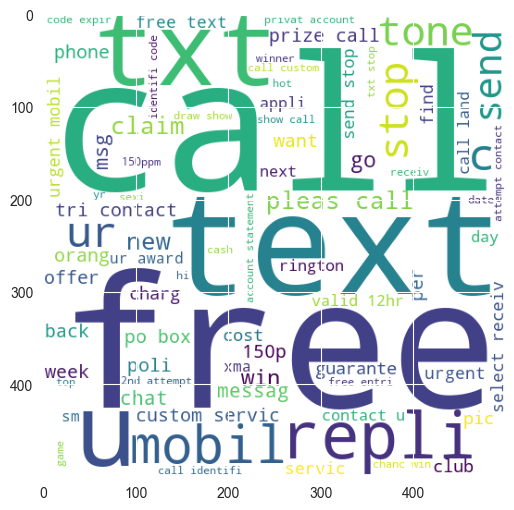

In [343]:
plt.figure(figsize=(15, 6))
plt.imshow(spam_wc)

In [344]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

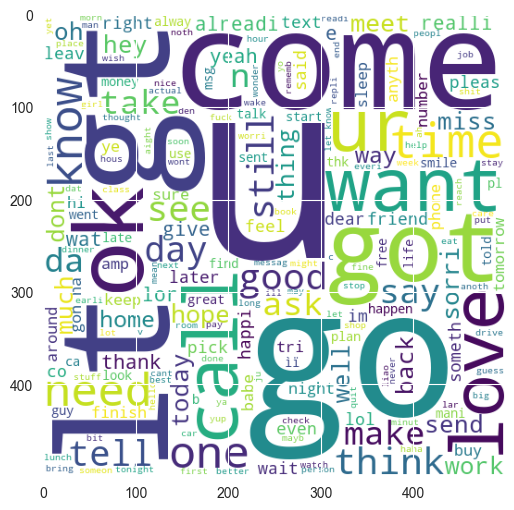

In [345]:
plt.figure(figsize=(15, 6))
plt.imshow(ham_wc)

In [346]:
df.head()

,target,text,num_characters,nums_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [347]:
spam_corpus = []

for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [348]:
len(spam_corpus)

9396

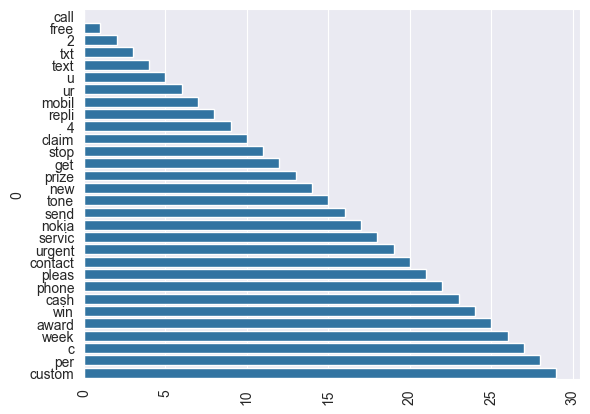

In [349]:
from collections import Counter
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0])
plt.xticks(rotation=90)
plt.show()

In [350]:
ham_corpus = []

for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [351]:
len(ham_corpus)

33638

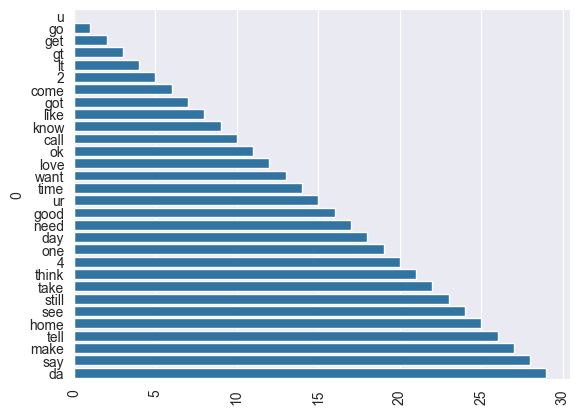

In [352]:
from collections import Counter
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0])
plt.xticks(rotation=90)
plt.show()

# 4. Model building

In [353]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer()
tfidf = TfidfVectorizer()

In [354]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [355]:
X.shape

(5169, 6437)

In [356]:
y = df['target'].values

In [357]:
y

array([0, 0, 1, ..., 0, 0, 0], shape=(5169,))

In [358]:
from sklearn.model_selection import train_test_split

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [360]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [361]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [362]:
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred_gnb))
print(confusion_matrix(y_test, y_pred_gnb))
print(precision_score(y_test, y_pred_gnb))

0.8626692456479691
[[780 116]
 [ 26 112]]
0.49122807017543857


In [363]:
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred_mnb))
print(confusion_matrix(y_test, y_pred_mnb))
print(precision_score(y_test, y_pred_mnb))

0.9555125725338491
[[896   0]
 [ 46  92]]
1.0


In [364]:
bnb.fit(X_train, y_train)
y_pred_bnb = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred_bnb))
print(confusion_matrix(y_test, y_pred_bnb))
print(precision_score(y_test, y_pred_bnb))

0.971953578336557
[[892   4]
 [ 25 113]]
0.9658119658119658


# 5. Evaluation

# 6. Improvement

# 7. Website